# COVID-19 forecast using a tensorflow: Case State of Algeria

The objective of this note book is to use a neural network model with tensorflow to predict the number of fatalities as a function of lagged values of the confirmed cases.

P.S: This notebook was inspired by a post I read on kaggle but I couldn't find it to put it in the reference. I will be grateful if someone can send me the link to add it. Thanks in advance.

In [1]:
import numpy as np
import pandas as pd
import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Reading data

In [2]:
# A function to read and clean the dataser
def read_csv(url, MIN_CASES = 10, SINCE_CASES_NUM = 10, death=False):
    '''
    Read csv file from the 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE on github. 
    It returns two datasets dff, dff2 and COL_X
    '''
    # Generate the first df cleaned
    df = pd.read_csv(url)
    # rename countries
    df['Country/Region'] = df['Country/Region'].replace({'Korea, South': 'South Korea'})
    # Remove Ships
    df = df[~df['Country/Region'].isin(['Cruise Ship'])]
        
    # Get the value's column
    dt_cols = df.columns[~df.columns.isin(['Province/State', 'Country/Region', 'Lat', 'Long'])]
    df = df.groupby('Country/Region')[dt_cols].sum()
       
    # Grouping by country, rename columns & parse dates
    dff = (df
           .stack().reset_index(name='Confirmed Cases')
           .rename(columns={'level_1': 'Date', 'Country/Region': 'Country'}))    
    for row in range(len(dff)):
        if re.match(r'\d{1}\/\d{1}\/\d{4}', str(dff.iloc[row, 1])):
            #dff['Date'] = dff['Date'].str[0:7] # first we keep only the '%m/%d/%y' format to avoid errors
            dff.iloc[row, 1] = '0' + dff.iloc[row, 1][0:2] + '0' + dff.iloc[row, 1][2:]

        elif re.match(r'\d{1}\/\d{2}\/\d{4}', str(dff.iloc[row, 1])):
            dff.iloc[row, 1] = '0' + dff.iloc[row, 1]

        elif re.match(r'\d{2}\/\d{1}\/\d{4}', str(dff.iloc[row, 1])):
            dff.iloc[row, 1] = dff.iloc[row, 1][0:4] + '0' + dff.iloc[row, 1][4:]
        elif re.match(r'\d+\/\d+\/\d{2}', str(dff.iloc[row, 1])):
            dff.iloc[row, 1] = dff.iloc[row, 1] + '20'
            #print(dff.iloc[row, 1])

    dff = dff[dff['Date'].str.contains('/20')]
    dff['Date'] = pd.to_datetime(dff['Date'], format='%m/%d/%Y')
    
    # Generate the second df with the minimum case
    LAST_DATE = dt_cols[-1]
    # sometimes last column may be empty, then go backwards
    for c in dt_cols[::-1]:
        if not df[c].fillna(0).eq(0).all():
            LAST_DATE = c
            break
    countries = dff[dff['Date'].eq(LAST_DATE) & dff['Confirmed Cases'].ge(MIN_CASES) #& 
            #dff['Country'].ne('China')
           ].sort_values(by='Confirmed Cases', ascending=False)
    countries = countries['Country'].values
    
    SINCE_CASES_NUM = SINCE_CASES_NUM
    COL_X = f'Days since {SINCE_CASES_NUM}th death'
    dff2 = dff[dff['Country'].isin(countries)].copy()
    days_since = (dff2.assign(F=dff2['Confirmed Cases'].ge(SINCE_CASES_NUM))
                  .set_index('Date')
                  .groupby('Country')['F'].transform('idxmax'))
    dff2[COL_X] = (dff2['Date'] - days_since.values).dt.days.values
    dff2 = dff2[dff2[COL_X].ge(0)]
    return dff, dff2

In [3]:
# URLs from the Data Repository by Johns Hopkins CSSE on github
# https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/

# Dataset downloaded on 08-04-2020
death_url = 'data/deaths.csv'
confirmed_url = 'data/cases.csv'

# Getting the datasets
death, death_since = read_csv(death_url, death=True)
confirmed, confirmed_since = read_csv(confirmed_url)

In [4]:
confirmed[confirmed['Country'] == 'Algeria'].head()

,Country,Date,Confirmed Cases
154,Algeria,2020-01-22,0
155,Algeria,2020-01-23,0
156,Algeria,2020-01-24,0
157,Algeria,2020-01-25,0
158,Algeria,2020-01-26,0


# Visualizing the evolution of the number of confirmed cases & deaths for the selected countries

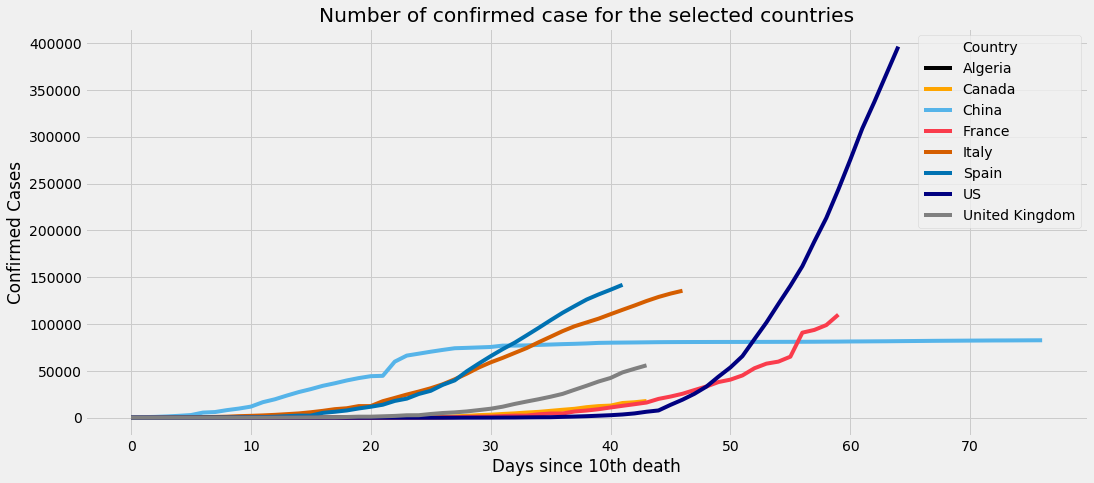

In [5]:
# List of countries to look at & corresponding colors
countries = ['Algeria', 'Canada', 'Italy', 'China', 'Spain', 'US', 'France', 'United Kingdom']
colors = [[0,0,0], [255/255,165/255, 0], [86/255,180/255,233/255], [250/255,60/255,76/255],
          [213/255,94/255,0], [0,114/255,178/255], [0,0,128/255], [128/255,128/255,128/255]]

# Plotting
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16, 7))
sns.lineplot(x='Days since 10th death', y='Confirmed Cases', hue='Country', data=confirmed_since.loc[confirmed_since['Country'].isin(countries)], palette=colors)
plt.title('Number of confirmed case for the selected countries')
plt.show() 

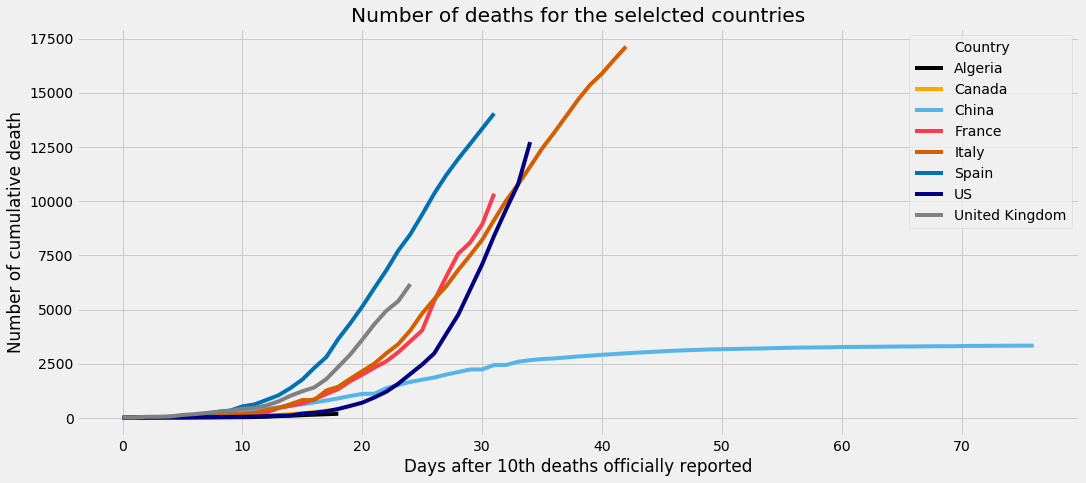

In [6]:
# Plotti,g the number of deaths for the selected countries
plt.figure(figsize=(16, 7))
sns.lineplot(x='Days since 10th death', y='Confirmed Cases', hue='Country', data=death_since[death_since['Country'].isin(countries)], palette=colors)
plt.title("Number of deaths for the selelcted countries")
plt.xlabel('Days after 10th deaths officially reported')
plt.ylabel('Number of cumulative death')
plt.show()

# Exlploring the relation between the number of fatalities and the confirmed cases (log values)

In [7]:
# Generate a dataset of a selected country with Confirmed, deaths cases & there correspondent logp1 values as columns

def country_data(country='Algeria'):
    '''
    Generate a dataset of a selected country with Confirmed, deaths cases & there correspondent logp1 values as columns.
    Returns the dataset
    '''

    df_cases = confirmed.loc[confirmed['Country'] == country, ['Confirmed Cases', 'Date']].reset_index(drop=True).set_index('Date').rename(columns={'Confirmed Cases': 'Confirmed_Cases'})
    df_deaths = death.loc[death['Country'] == country, ['Confirmed Cases', 'Date']].reset_index(drop=True).set_index('Date').rename(columns={'Confirmed Cases': 'Confirmed_Cases'})

    df = df_cases.join(df_deaths, rsuffix='_deaths').query('Confirmed_Cases>Confirmed_Cases_deaths')
    df = df.assign(logp_cases = np.log1p(df.Confirmed_Cases),
                   logp_deaths = np.log1p(df.Confirmed_Cases_deaths))
    
    return df.dropna(axis=0)

In [8]:
# List of the dataframes of the selected countries
dfs = [country_data(country=country) for country in countries]

In [9]:
def plot_log_CaseDeath(df = dfs[0], country=countries[0], delta=0, cases=2, deaths = 3):
    x_1 = np.array(range(df.shape[0]))
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.plot(df.iloc[:, cases].values)
    ax.plot(df.iloc[delta:, deaths].values)
    if delta == 0:
        plt.title(f'Number of confirmed cases vs. deaths for {country} (log values)')
        plt.legend(('log_confirmed_cases', 'log_deaths'))
    else:
        plt.title(f'Number of confirmed cases vs. deaths for {country}\n(Ajusted values with a lag of {delta} days)')
        plt.legend(('log_confirmed_cases', 'Ajusted_log_deaths'))
    plt.xlabel('Days since the 1st reported case')
    plt.ylabel('Values (log)')
    plt.show()

### Visualizing the evolution of these variables (log values)

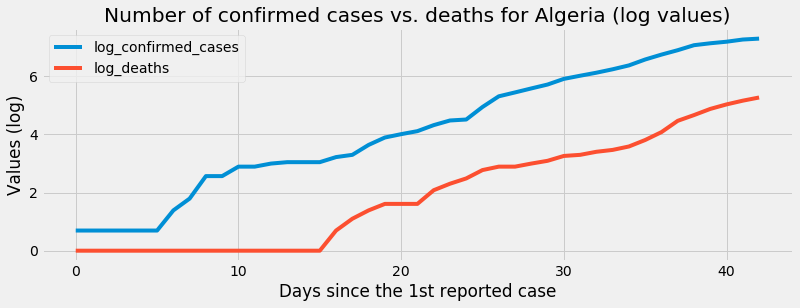

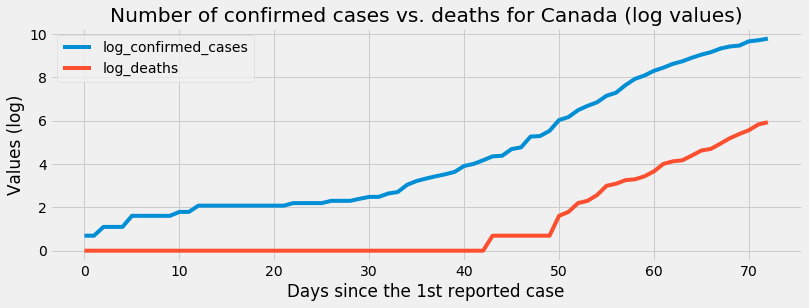

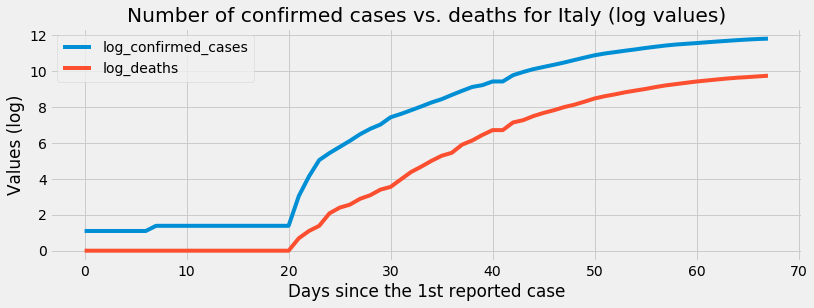

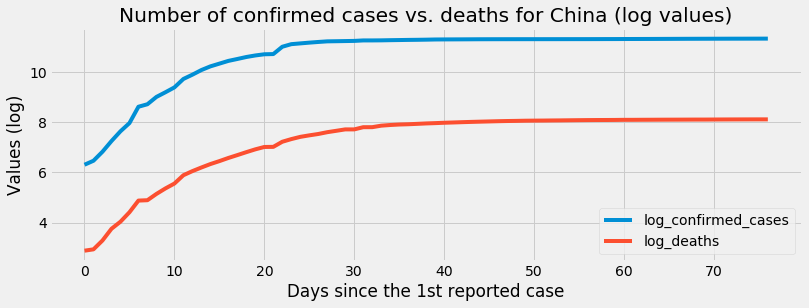

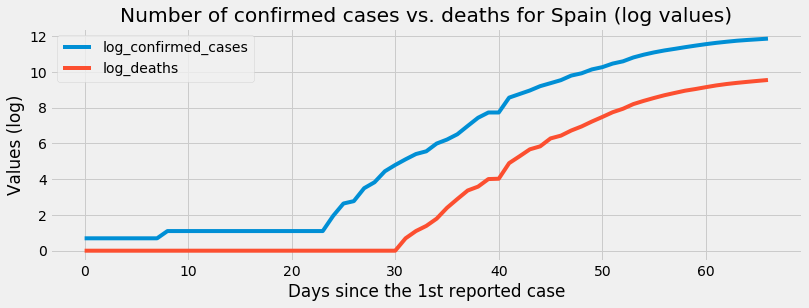

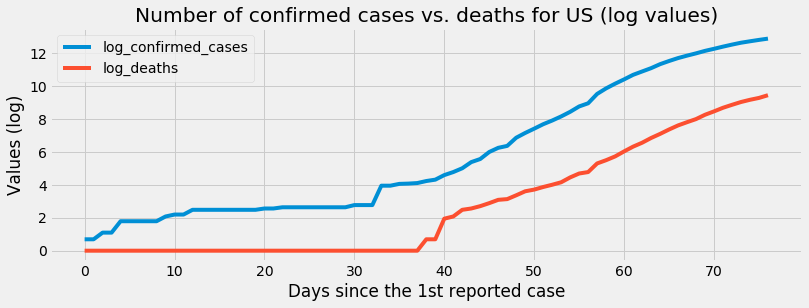

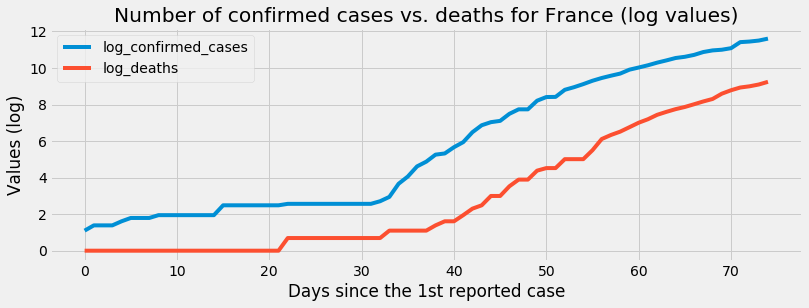

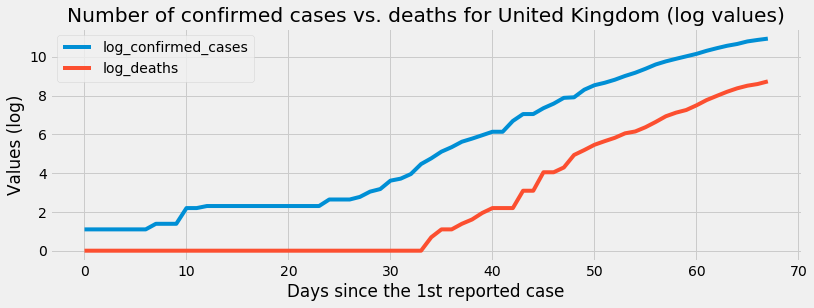

In [10]:
for idx in range(len(dfs)):
    plot_log_CaseDeath(df= dfs[idx], country=countries[idx], delta=0)

### Calculate the delta of each country

Let's create a function to calculate the lag (in days) between the two variables for the given countries.

In [11]:
def get_delta(df=dfs[0], cases=2, deaths = 3):
    for num in range(1, 30):
        shift = pd.DataFrame(data=df.iloc[:, cases].values - df.iloc[:, deaths].shift(-num).values, columns=['value'])
        shift.dropna(axis=0, inplace=True)
        if len(shift.query('value > 0')) != len(shift):   # We need to check if all the values of log_deaths are less than log_cases
            break
        else : 
            sum_shift = shift.sum() / len(shift)
    return num

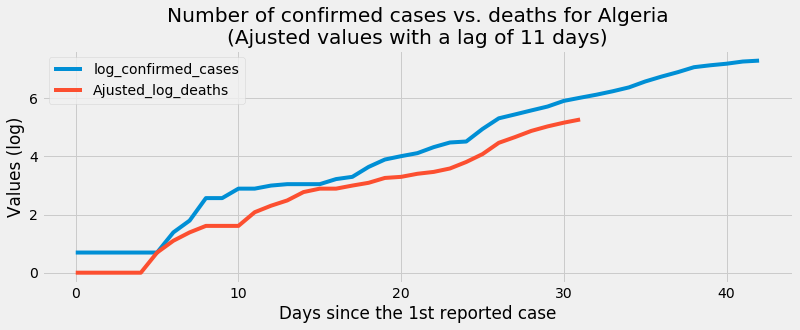

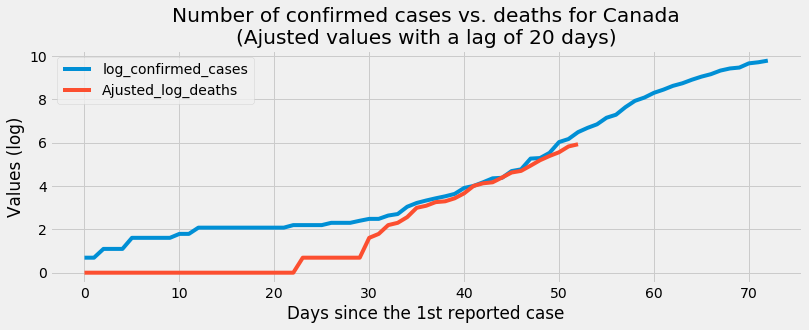

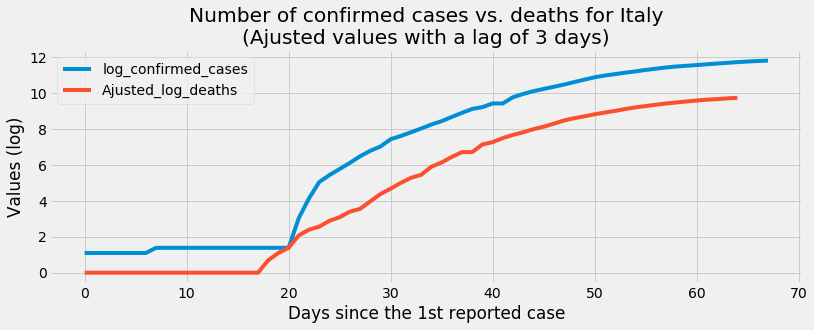

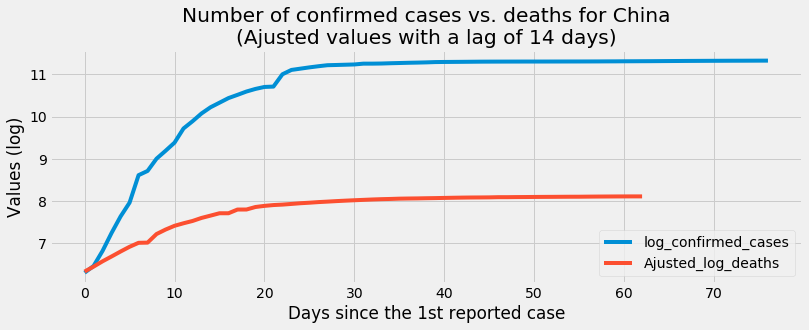

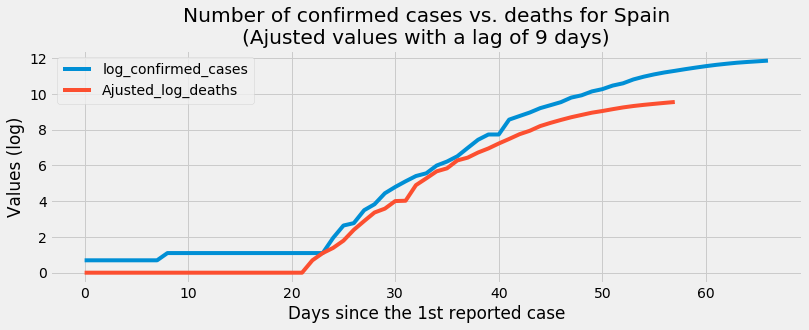

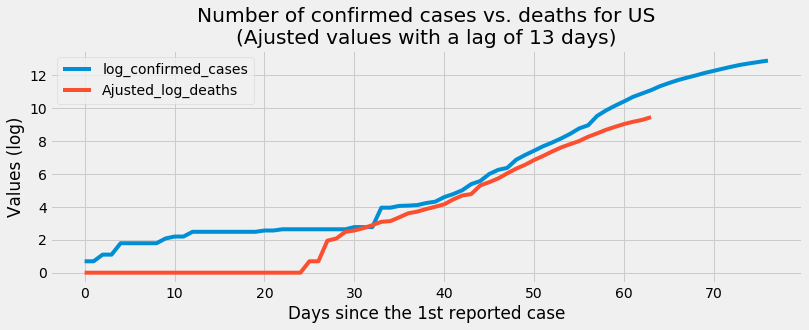

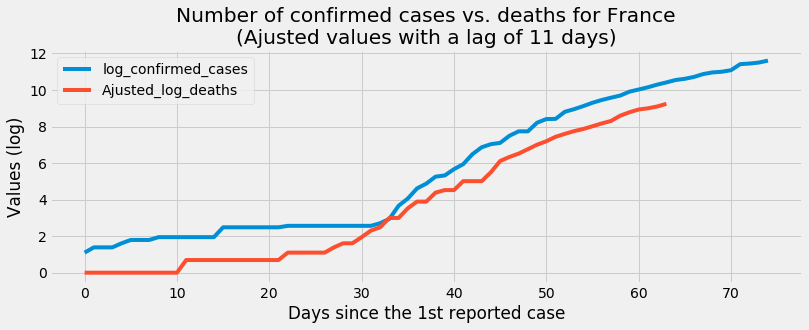

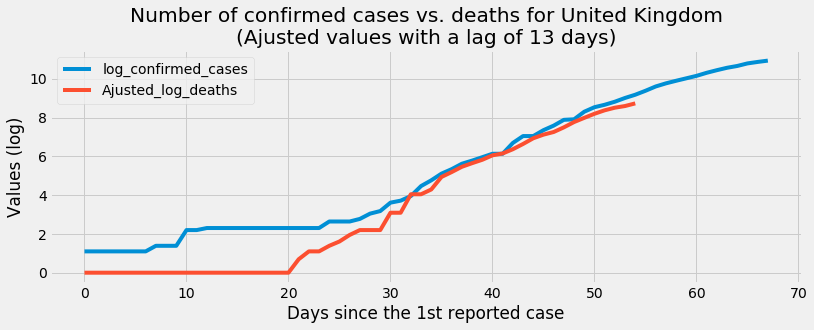

In [12]:
dlt = []
for df in dfs:
    dlt.append(get_delta(df))
    
for idx in range(len(dfs)):
    plot_log_CaseDeath(df= dfs[idx], country=countries[idx], delta=dlt[idx])

# Using a Neural Network model to predict the fatalities for Algeria

In [13]:
# Defining the country and the corresponding delta
idx = 0
print(dlt[idx])
print(countries[idx])
dfs[idx].tail()

11
Algeria


,Confirmed_Cases,Confirmed_Cases_deaths,logp_cases,logp_deaths
Date,,,,
2020-04-03,1171,105,7.066467,4.663439
2020-04-04,1251,130,7.132498,4.875197
2020-04-05,1320,152,7.186144,5.030438
2020-04-06,1423,173,7.261225,5.159055
2020-04-07,1468,193,7.292337,5.267858


I will use the shifted values of confirmed cases (t - delta) to predict the value of fatalities at the given date (t)

In [14]:
# I use the absolute values of fatalities and confirmed cases as it gives better results.
label =  'Confirmed_Cases_deaths'
feature = 'Confirmed_Cases' 

# Define X and y
X = dfs[idx][[feature]].values.reshape(-1, 1)
y = dfs[idx][[label]].shift(-dlt[idx]).dropna(axis=0).values.reshape(-1, 1)
# The remainig values of cases will serve for to predictions
X_valid = X[len(y):]
X = X[:len(y)]

print(f'X shape : {X.shape}')
print(f'X_valid shape : {X_valid.shape}')
print(f'y shape : {y.shape}')
print(dlt[idx])

X shape : (32, 1)
X_valid shape : (11, 1)
y shape : (32, 1)
11


### Building the model

In [15]:
# Early stopping callback

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=50, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

# Create the model
model = keras.Sequential([
    layers.Flatten(),
    layers.Dense(64, input_shape=(X.shape[0], ), activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
  ])

optimizer = tf.keras.optimizers.RMSprop(0.001)
# optimizer = tf.keras.optimizers.Adam()

model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae', 'mse'])

In [16]:
history = model.fit(X, y, 
                    epochs=50, verbose=0,
                   callbacks=[callbacks])

In [17]:
# Checking the evolution of the metrics
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,epoch
45,19.132030,3.220400,19.132030,45
46,18.351316,3.161500,18.351316,46
47,17.782158,3.109813,17.782158,47
48,17.377079,3.066626,17.377079,48
49,17.095692,3.029458,17.095692,49


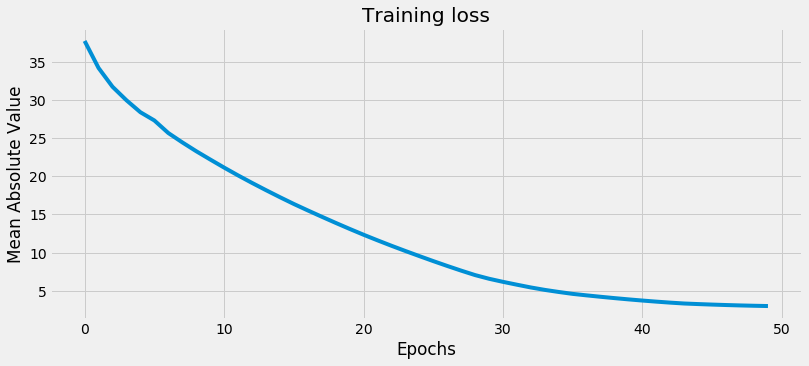

In [18]:
# Plotting the train loss
plt.figure(figsize=(12, 5))
hist.mae.plot()
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Value')
plt.show()

### Predictions and visualizing the results

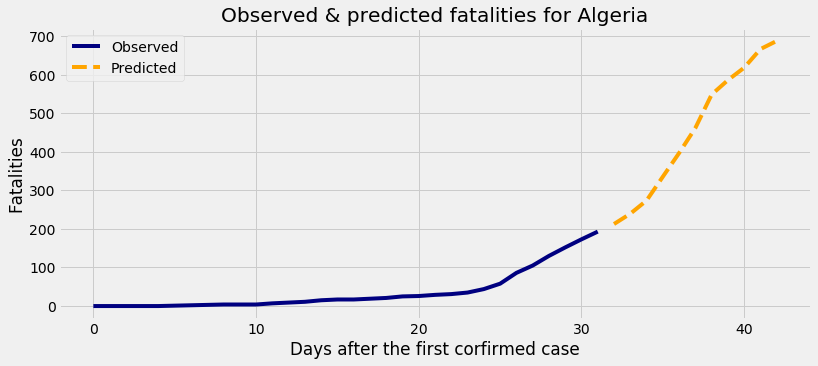

In [19]:
# Defining the indexes
x = list(range(len(X)))
xx = list(range(len(X), len(X) +len(X_valid)))

# Predictions
predictions = model.predict(X_valid)
predictions = pd.Series(data=predictions.ravel(), index=xx)

# Plot
colors = [[255/255,165/255, 0], [0,0,128/255]]

plt.figure(figsize=(12, 5))
plt.plot(x, y, label='Observed', c=colors[1])
predictions.plot(label='Predicted', linestyle='dashed', c=colors[0])
plt.legend()
plt.title('Observed & predicted fatalities for Algeria')
plt.xlabel('Days after the first corfirmed case')
plt.ylabel('Fatalities')
plt.show()

In [20]:
# Predictions values for the period 08-4-2020 to 18-04-2020
print('The predicted values of fatalities for the period 08-4-2020 to 18-04-2020 :')
predictions.values.astype(int)

The predicted values of fatalities for the period 08-4-2020 to 18-04-2020 :


array([212, 239, 273, 335, 396, 461, 548, 585, 618, 666, 687])

I wish the community mitigation strategy adopted by the country/population and the incredible efforts of the medical community will make these figures inaccurate. This hope is is valid for all the countries around the world. Stay safe all.